In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


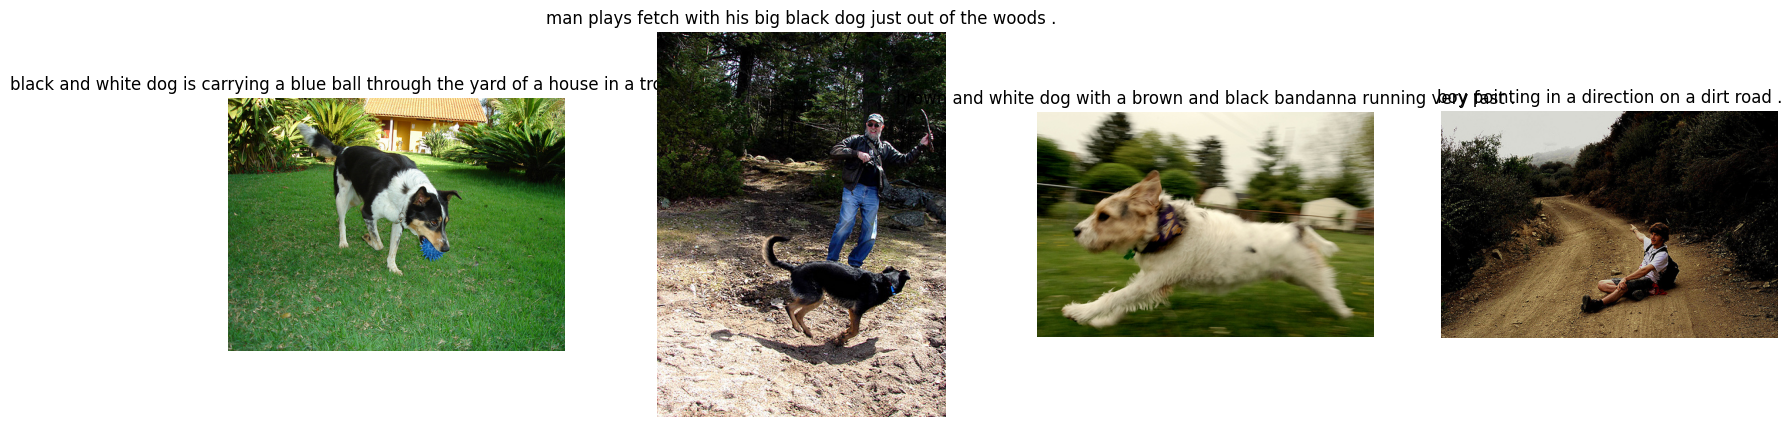

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load captions
def load_captions(filename):
    """Load captions from the provided filename."""
    with open(filename, 'r') as file:
        data = file.readlines()
    captions_dict = {}
    for line in data:
        tokens = line.strip().split()
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id in captions_dict:
            captions_dict[image_id].append(image_desc)
        else:
            captions_dict[image_id] = [image_desc]
    return captions_dict

captions_filename = '/content/drive/MyDrive/Colab Notebooks/data/flicker8k/captions.txt' # 'Flickr8k_text/Flickr8k.token.txt'
captions_dict = load_captions(captions_filename)

# Display random images with captions
def display_random_images(n, dataset_folder, captions_dict):
    """Display n random images with their captions."""
    images = os.listdir(dataset_folder)
    selected_images = np.random.choice(images, n)

    plt.figure(figsize=(20, 5))
    for idx, image_file in enumerate(selected_images):
        image_path = os.path.join(dataset_folder, image_file)
        image_id = image_file.split('.')[0]
        captions = captions_dict[image_id]

        img = plt.imread(image_path)
        plt.subplot(1, n, idx+1)
        plt.imshow(img)
        plt.title(captions[0])  # displaying only the first caption
        plt.axis('off')

    plt.show()

dataset_folder = '/content/drive/MyDrive/Colab Notebooks/data/flicker8k/Images'# 'Flicker8k_Dataset'
display_random_images(4, dataset_folder, captions_dict)


In [3]:
import pandas as pd

# Load captions into DataFrame
def load_captions_into_dataframe(filename):
    with open(filename, 'r') as file:
        data = file.readlines()
    image_names = []
    captions = []
    for line in data:
        tokens = line.strip().split()
        image_name, image_caption = tokens[0], tokens[1:]
        image_name = image_name.split('.')[0]  # Removing the .jpg extension
        image_caption = ' '.join(image_caption)
        image_names.append(image_name)
        captions.append(image_caption)
    df = pd.DataFrame(list(zip(image_names, captions)), columns=['image_name', 'caption'])
    return df

df = load_captions_into_dataframe(captions_filename)
df = df. tail(-1).reset_index(drop = True) # drop first record
df.head()

,image_name,caption
0,1000268201_693b08cb0e,child in a pink dress is climbing up a set of ...
1,1000268201_693b08cb0e,girl going into a wooden building .
2,1000268201_693b08cb0e,little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e,little girl climbing the stairs to her playhou...
4,1000268201_693b08cb0e,little girl in a pink dress going into a woode...


In [4]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Image Preprocessing
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # VGG16-specific preprocessing
    return img[0]

# Sample image preprocessing
image_sample_path = os.path.join(dataset_folder, df.image_name[0] + '.jpg')
processed_img = preprocess_image(image_sample_path)
print("Processed image shape:", processed_img.shape)



Processed image shape: (224, 224, 3)


In [5]:
# Text Preprocessing
df['caption'] = df['caption'].apply(lambda x: '<start> ' + x + ' <end>')

# Tokenizing
tokenizer = Tokenizer(num_words=5000, oov_token="<oov>")
tokenizer.fit_on_texts(df['caption'])
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:", vocab_size)



Vocab size: 8414


In [6]:
# Convert text sequences to integer sequences
df['sequence'] = tokenizer.texts_to_sequences(df['caption'])
max_sequence_len = max([len(seq) for seq in df['sequence']])
print("Max sequence length:", max_sequence_len)



Max sequence length: 38


In [7]:
# Pad sequences
df['sequence'] = pad_sequences(df['sequence'], maxlen=max_sequence_len, padding='post').tolist()
df.head()

,image_name,caption,sequence
0,1000268201_693b08cb0e,<start> child in a pink dress is climbing up a...,"[3, 43, 5, 4, 89, 171, 8, 119, 50, 4, 386, 13,..."
1,1000268201_693b08cb0e,<start> girl going into a wooden building . <end>,"[3, 19, 311, 60, 4, 193, 117, 2, 0, 0, 0, 0, 0..."
2,1000268201_693b08cb0e,<start> little girl climbing into a wooden pla...,"[3, 41, 19, 119, 60, 4, 193, 2418, 2, 0, 0, 0,..."
3,1000268201_693b08cb0e,<start> little girl climbing the stairs to her...,"[3, 41, 19, 119, 6, 387, 20, 57, 2418, 2, 0, 0..."
4,1000268201_693b08cb0e,<start> little girl in a pink dress going into...,"[3, 41, 19, 5, 4, 89, 171, 311, 60, 4, 193, 29..."


In [8]:
from sklearn.model_selection import train_test_split

# Splitting data
train_df, temp_df = train_test_split(df, test_size=0.1, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

# Load VGG16 model + higher level layers
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

# def extract_features(df, folder):
#     features = {}
#     for img_name in df['image_name']:
#         filename = folder + "/" + img_name + ".jpg"
#         image = preprocess_image(filename)
#         feature = model.predict(image.reshape((1, image.shape[0], image.shape[1], image.shape[2])))
#         features[img_name] = feature
#     return features

# train_features = extract_features(train_df, dataset_folder)
# val_features = extract_features(val_df, dataset_folder)
# test_features = extract_features(test_df, dataset_folder)

from tqdm import tqdm

def extract_features_batched(df, folder, batch_size=32):
    features = {}
    num_images = len(df)
    for i in tqdm(range(0, num_images, batch_size), total=num_images//batch_size + (num_images % batch_size != 0)):
        batch_images = []
        end = min(i+batch_size, num_images)
        img_names_batch = df['image_name'][i:end].values
        for img_name in img_names_batch:
            filename = os.path.join(folder, img_name + ".jpg")
            image = preprocess_image(filename)
            batch_images.append(image)
        batch_images = np.array(batch_images)
        batch_features = model.predict(batch_images,verbose = 0)
        for idx, img_name in enumerate(img_names_batch):
            features[img_name] = batch_features[idx]
    return features

train_features = extract_features_batched(train_df, dataset_folder)


553467096/553467096 [==============================] - 3s 0us/step


  7%|▋         | 84/1138 [31:30<6:07:48, 20.94s/it]

In [ ]:
val_features = extract_features_batched(val_df, dataset_folder)


In [ ]:
test_features = extract_features_batched(test_df, dataset_folder)

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense, Add, Dropout
from keras.models import Model

# Define model
embedding_dim = 256
units = 256

# Image features input
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(units, activation='relu')(fe1)

# Partial caption sequence input
inputs2 = Input(shape=(max_sequence_len,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(units)(se2)

# Decoder (feed forward)
decoder1 = Add()([fe2, se3])
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Merge inputs to create the final model
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')


In [ ]:
# Save the caption model
caption_model_path = 'caption_model.h5'
caption_model.save(caption_model_path)

# Save the tokenizer using pickle
import pickle
tokenizer_path = 'tokenizer.pkl'
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)


In [ ]:
# def generate_caption(model, tokenizer, image, max_length):
#     in_text = '<start>'
#     for _ in range(max_length):
#         sequence = tokenizer.texts_to_sequences([in_text])[0]
#         sequence = pad_sequences([sequence], maxlen=max_length)
#         yhat = model.predict([image, sequence], verbose=0)
#         yhat = np.argmax(yhat)
#         word = tokenizer.index_word[yhat]
#         in_text += ' ' + word
#         if word == '<end>':
#             break
#     return in_text

from keras.preprocessing.sequence import pad_sequences

def generate_caption(model, tokenizer, image, max_length):
    in_text = '<start>'
    image = image.reshape((1, -1))  # Reshape the image features to fit the model's expected input shape

    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='pre')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat, "?")
        if word == '<end>':
            break
        in_text += ' ' + word

    # Remove <start> and <end> tokens for the final output
    final_caption = in_text.replace('<start> ', '').replace(' <end>', '')
    return final_caption


In [ ]:

# def evaluate_model(model, descriptions, photos, tokenizer, max_length):
#     actual, predicted = list(), list()
#     for key, desc_list in descriptions.items():
#         yhat = generate_caption(model, tokenizer, photos[key], max_length)
#         references = [d.split() for d in desc_list]
#         actual.append(references)
#         predicted.append(yhat.split())

#     # Calculate BLEU scores
#     bleu1 = sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
#     bleu2 = sentence_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
#     bleu3 = sentence_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
#     bleu4 = sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

#     print(f"BLEU-1: {bleu1:.4f}")
#     print(f"BLEU-2: {bleu2:.4f}")
#     print(f"BLEU-3: {bleu3:.4f}")
#     print(f"BLEU-4: {bleu4:.4f}")
#     return bleu1, bleu2, bleu3, bleu4

# # Convert dataframe back to dictionary format for evaluation
# descriptions = test_df.groupby('image_name')['caption'].apply(list).to_dict()
# photos = test_features

# # Evaluate
# bleu_scores = evaluate_model(caption_model, descriptions, photos, tokenizer, max_sequence_len)
# bleu_scores

In [ ]:
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key in tqdm(descriptions.keys(), desc="Generating captions", unit="image"):
        yhat = generate_caption(model, tokenizer, photos[key], max_length)
        references = [d.split() for d in descriptions[key]]
        actual.append(references)
        predicted.append(yhat.split())

    # ... (rest of the function remains unchanged)

    # Calculate BLEU scores
    bleu1 = sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = sentence_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = sentence_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu4 = sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-2: {bleu2:.4f}")
    print(f"BLEU-3: {bleu3:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")
    return bleu1, bleu2, bleu3, bleu4

# Convert dataframe back to dictionary format for evaluation
descriptions = test_df.groupby('image_name')['caption'].apply(list).to_dict()
photos = test_features

# Evaluate
bleu_scores = evaluate_model(caption_model, descriptions, photos, tokenizer, max_sequence_len)
bleu_scores